CELL 1 — Imports + seeds

In [1]:
# OS utilities
import os  # paths

# Arrays
import numpy as np  # arrays

# Pickle (for scaler)
import pickle  # load scaler

# EEG tools
import mne  # filtering + resampling
import pywt  # wavelets

# ML
from sklearn.decomposition import FastICA  # ICA

# Deep learning
import tensorflow as tf  # TF
from tensorflow import keras  # Keras

# Explainability + tables + progress
import shap  # SHAP
import pandas as pd  # DataFrame
from tqdm import tqdm  # progress bar

# Plotting
import matplotlib.pyplot as plt  # plots
import seaborn as sns  # heatmaps

# Seeds
import random  # random
random.seed(42)  # seed
np.random.seed(42)  # seed
tf.random.set_seed(42)  # seed

print("✅ Imports loaded and seeds set.")


C:\Users\HP\anaconda3\envs\DL\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.6 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "
C:\Users\HP\anaconda3\envs\DL\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Imports loaded and seeds set.


CELL 2 — Load trained MLP + scaler

In [2]:
print("=" * 80)
print("[STEP 1] LOADING MLP MODEL + SCALER")
print("=" * 80)

# ✅ Update if your paths are different
MODEL_PATH  = r"band_features_mlp.keras"         # model file
SCALER_PATH = r"band_features_scaler.pkl"        # scaler file

# Load model
model = keras.models.load_model(MODEL_PATH, compile=False)  # load model
model.compile(  # compile for prediction consistency
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[keras.metrics.BinaryAccuracy(name="accuracy", threshold=0.5)]
)
print("✅ Model loaded:", MODEL_PATH)

# Load scaler
with open(SCALER_PATH, "rb") as f:
    scaler = pickle.load(f)  # load scaler
print("✅ Scaler loaded:", SCALER_PATH)

# Print model summary
model.summary()


[STEP 1] LOADING MLP MODEL + SCALER
✅ Model loaded: band_features_mlp.keras
✅ Scaler loaded: band_features_scaler.pkl


C:\Users\HP\anaconda3\envs\DL\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 737 (2.88 KB)

 Trainable params: 737 (2.88 KB)

 Non-trainable params: 0 (0.00 B)

CELL 3 — Load ONLY excluded trials

In [3]:
print("=" * 80)
print("[STEP 2] LOADING LOCAL EEG ARRAYS (UNCHANGED)")
print("=" * 80)

NEG_PATH = r"D:\Dermerzel\SomnasNest\Alzheimer\Data\ad_negative.npy"  # local path
POS_PATH = r"D:\Dermerzel\SomnasNest\Alzheimer\Data\ad_positive.npy"  # local path

X_neg_full = np.load(NEG_PATH).astype(np.float32)  # load negative
X_pos_full = np.load(POS_PATH).astype(np.float32)  # load positive

print("✅ Arrays loaded.")
print("X_neg_full:", X_neg_full.shape)
print("X_pos_full:", X_pos_full.shape)

# Extract excluded last 5 (same logic)
X_neg_excluded = X_neg_full[-5:]  # excluded neg
X_pos_excluded = X_pos_full[-5:]  # excluded pos

print("✅ Excluded extracted.")
print("X_neg_excluded:", X_neg_excluded.shape)
print("X_pos_excluded:", X_pos_excluded.shape)


[STEP 2] LOADING LOCAL EEG ARRAYS (UNCHANGED)
✅ Arrays loaded.
X_neg_full: (31, 127, 150000)
X_pos_full: (46, 127, 150000)
✅ Excluded extracted.
X_neg_excluded: (5, 127, 150000)
X_pos_excluded: (5, 127, 150000)


CELL 4 — Select one excluded trial

In [4]:
print("=" * 80)
print("[STEP 3] SELECTING ONE EXCLUDED TRIAL")
print("=" * 80)

USE_CLASS = "pos"       # "pos" or "neg"
EXCLUDED_INDEX = -1     # -1 = last excluded trial

if USE_CLASS == "pos":
    X_test_trial = X_pos_excluded[EXCLUDED_INDEX]  # (C,T)
    y_test_trial = 1  # target
else:
    X_test_trial = X_neg_excluded[EXCLUDED_INDEX]  # (C,T)
    y_test_trial = 0  # target

print("✅ Selected trial.")
print("USE_CLASS:", USE_CLASS)
print("Trial shape:", X_test_trial.shape)
print("Ground truth:", y_test_trial)


[STEP 3] SELECTING ONE EXCLUDED TRIAL
✅ Selected trial.
USE_CLASS: pos
Trial shape: (127, 150000)
Ground truth: 1


CELL 4 — Select one excluded trial

In [5]:
print("=" * 80)
print("[STEP 3] SELECTING ONE EXCLUDED TRIAL")
print("=" * 80)

USE_CLASS = "pos"       # "pos" or "neg"
EXCLUDED_INDEX = -1     # -1 = last excluded trial

if USE_CLASS == "pos":
    X_test_trial = X_pos_excluded[EXCLUDED_INDEX]  # (C,T)
    y_test_trial = 1  # target
else:
    X_test_trial = X_neg_excluded[EXCLUDED_INDEX]  # (C,T)
    y_test_trial = 0  # target

print("✅ Selected trial.")
print("USE_CLASS:", USE_CLASS)
print("Trial shape:", X_test_trial.shape)
print("Ground truth:", y_test_trial)


[STEP 3] SELECTING ONE EXCLUDED TRIAL
✅ Selected trial.
USE_CLASS: pos
Trial shape: (127, 150000)
Ground truth: 1


CELL 5 — Downsample 1000 Hz → 500 Hz

In [6]:
print("=" * 80)
print("[STEP 4] DOWNSAMPLING TO 500 Hz")
print("=" * 80)

sfreq_in = 1000  # input Hz
sfreq_out = 500  # output Hz
fs = float(sfreq_out)  # store fs

down_factor = int(sfreq_in // sfreq_out)  # 2
print("down_factor:", down_factor)

X_test_trial = mne.filter.resample(
    X_test_trial.astype(np.float64, copy=False),  # to float64
    down=down_factor,  # downsample
    npad="auto",  # pad
    axis=-1,  # time axis
    verbose=True
).astype(np.float32, copy=False)  # back to float32

print("✅ Downsampled.")
print("X_test_trial:", X_test_trial.shape, X_test_trial.dtype)
print("fs:", fs)


[STEP 4] DOWNSAMPLING TO 500 Hz
down_factor: 2
✅ Downsampled.
X_test_trial: (127, 75000) float32
fs: 500.0


CELL 6 — Training-style preprocessing

In [7]:
print("=" * 80)
print("[STEP 5] DEFINING TRAINING-STYLE PREPROCESSOR")
print("=" * 80)

def _names_from_index_mapping(n_channels):
    return [f"EEG{i+1}" for i in range(n_channels)]  # auto channel names

def _make_raw(eeg, sfreq, ch_names):
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types="eeg")  # info
    raw = mne.io.RawArray(eeg.astype(np.float32, copy=False), info, verbose=False)  # raw
    return raw  # return

class WaveletICA:
    def __init__(self, wavelet="db4", level=3, n_components=10, random_state=42):
        self.wavelet = wavelet  # wavelet name
        self.level = level  # level
        self.n_components = n_components  # components
        self.random_state = random_state  # seed
        self.ica_ = None  # store ICA

    def fit(self, X):
        coeffs = pywt.wavedec(X, wavelet=self.wavelet, level=self.level, axis=1)  # wavelet decomp
        A = coeffs[0]  # approx coeffs
        k = int(min(self.n_components, X.shape[0]))  # cap by channels
        self.ica_ = FastICA(n_components=k, random_state=self.random_state)  # ICA
        S = self.ica_.fit_transform(A.T)  # fit ICA
        A_denoised = self.ica_.inverse_transform(S).T  # reconstruct
        coeffs[0] = A_denoised  # replace
        _ = pywt.waverec(coeffs, wavelet=self.wavelet, axis=1)  # recon (fit)
        return self

    def transform(self, X):
        assert self.ica_ is not None, "WaveletICA not fitted."  # check fitted
        coeffs = pywt.wavedec(X, wavelet=self.wavelet, level=self.level, axis=1)  # wavelet decomp
        A = coeffs[0]  # approx coeffs
        S = self.ica_.transform(A.T)  # ICA transform
        A_denoised = self.ica_.inverse_transform(S).T  # inverse
        coeffs[0] = A_denoised  # replace
        Y = pywt.waverec(coeffs, wavelet=self.wavelet, axis=1)  # reconstruct

        # length fix
        if Y.shape[1] < X.shape[1]:
            Y = np.pad(Y, ((0, 0), (0, X.shape[1] - Y.shape[1])), mode="constant")
        if Y.shape[1] > X.shape[1]:
            Y = Y[:, :X.shape[1]]

        return Y.astype(np.float32, copy=False)

class EEGPreprocessor:
    def __init__(self, notch_freqs=(50.0,100.0,150.0), highpass=0.05, car=True,
                 use_wica=True, wica_components=10, wica_wavelet="db4", wica_level=3, wica_random_state=42):
        self.notch_freqs = notch_freqs  # notch list
        self.highpass = highpass  # hp cutoff
        self.car = car  # avg ref
        self.use_wica = use_wica  # WICA on/off
        self._train_mu = None  # train mean
        self._train_sd = None  # train std
        self._wica = WaveletICA(wavelet=wica_wavelet, level=wica_level,
                                n_components=wica_components, random_state=wica_random_state)  # WICA

    def _filter_ref(self, raw):
        raw.notch_filter(list(self.notch_freqs), verbose=False)  # notch
        raw.filter(l_freq=self.highpass, h_freq=None, verbose=False)  # highpass
        if self.car:
            raw.set_eeg_reference("average", projection=True)  # CAR
            raw.apply_proj()  # apply

    def fit(self, X_calib, sfreq):
        ch_names = _names_from_index_mapping(X_calib.shape[0])  # names
        raw = _make_raw(X_calib, sfreq, ch_names)  # raw
        self._filter_ref(raw)  # filter+ref
        Xt = raw.get_data()  # get data
        self._train_mu = Xt.mean(axis=1, keepdims=True)  # mean
        self._train_sd = Xt.std(axis=1, keepdims=True) + 1e-12  # std
        if self.use_wica:
            self._wica.fit(Xt)  # fit WICA
        return self

    def transform(self, X, sfreq):
        ch_names = _names_from_index_mapping(X.shape[0])  # names
        raw = _make_raw(X, sfreq, ch_names)  # raw
        self._filter_ref(raw)  # filter+ref
        Xt = raw.get_data()  # data
        if self.use_wica:
            Xt = self._wica.transform(Xt)  # WICA
        return Xt.astype(np.float32, copy=False)

print("✅ Preprocessor classes ready.")


[STEP 5] DEFINING TRAINING-STYLE PREPROCESSOR
✅ Preprocessor classes ready.


CELL 7 — Fit preprocessor using non-excluded calibration trials + preprocess test trial

In [8]:
print("=" * 80)
print("[STEP 6] FITTING PREPROCESSOR (CALIBRATION LIKE TRAINING)")
print("=" * 80)

# Build calibration pool (exclude last 5 trials)
X_pool = np.concatenate([X_neg_full[:-5], X_pos_full[:-5]], axis=0).astype(np.float32, copy=False)  # pool
max_calib_trials = min(10, X_pool.shape[0])  # same idea as training
print("Calibration trials:", max_calib_trials)

# Downsample calibration trials to 500 Hz (same as test)
calib_ds = []  # list
for i in range(max_calib_trials):
    trial = X_pool[i]  # trial
    trial_ds = mne.filter.resample(
        trial.astype(np.float64, copy=False),
        down=int(1000 // fs),  # 2
        npad="auto",
        axis=-1,
        verbose=False
    ).astype(np.float32, copy=False)
    calib_ds.append(trial_ds)

# Concatenate across time for calibration
X_calib = np.concatenate(calib_ds, axis=1).astype(np.float32, copy=False)  # concat
print("X_calib shape:", X_calib.shape)

# Fit preprocessor
pre = EEGPreprocessor()  # create preprocessor
pre.fit(X_calib, fs)  # fit
print("✅ Preprocessor fitted.")

# Transform test trial
X_clean = pre.transform(X_test_trial, fs)  # transform
print("✅ Test trial cleaned.")
print("X_clean shape:", X_clean.shape)


[STEP 6] FITTING PREPROCESSOR (CALIBRATION LIKE TRAINING)
Calibration trials: 10
X_calib shape: (127, 750000)
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
✅ Preprocessor fitted.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
✅ Test trial cleaned.
X_clean shape: (127, 75000)


CELL 8 — Segment EXACTLY like training

In [9]:
print("=" * 80)
print("[STEP 7] SEGMENTING (MATCH TRAINING)")
print("=" * 80)

segment_seconds = 2.0  # 2 seconds
segment_size = int(segment_seconds * fs)  # 1000 at 500 Hz

print("fs:", fs)
print("segment_seconds:", segment_seconds)
print("segment_size:", segment_size)

def segment_trial(trial_2d, label, segment_size):
    segments = []  # segments
    labels = []  # labels
    n_segments = trial_2d.shape[1] // segment_size  # full segments
    for i in range(n_segments):
        seg = trial_2d[:, i*segment_size:(i+1)*segment_size]  # slice
        segments.append(seg.astype(np.float32, copy=False))  # store
        labels.append(int(label))  # store label
    return segments, labels

segments, labels = segment_trial(X_clean, y_test_trial, segment_size)  # segment
X_test_segments = np.array(segments, dtype=np.float32)  # (n_seg, C, T)
y_true_segments = np.array(labels, dtype=np.int32)  # (n_seg,)

print("✅ Segmentation done.")
print("X_test_segments:", X_test_segments.shape)
print("y_true_segments:", y_true_segments.shape)


[STEP 7] SEGMENTING (MATCH TRAINING)
fs: 500.0
segment_seconds: 2.0
segment_size: 1000
✅ Segmentation done.
X_test_segments: (75, 127, 1000)
y_true_segments: (75,)


CELL 9 — Extract 5-band features per segment

In [13]:
print("=" * 80)
print("[STEP 8] EXTRACTING 5 BAND FEATURES (LIKE TRAINING)")
print("=" * 80)

# Band definitions (Hz)
BANDS = {
    "delta": (0.5, 4.0),
    "theta": (4.0, 8.0),
    "alpha": (8.0, 13.0),
    "beta":  (13.0, 30.0),
    "gamma": (30.0, 45.0),
}

print("[STEP 8] Bands:", BANDS)
print("[STEP 8] X_test_segments:", X_test_segments.shape, X_test_segments.dtype)
print("[STEP 8] fs:", fs)

def segment_band_features_mean_over_channels(seg_2d, fs):
    """
    Compute 5 band log-power features for ONE segment.
    seg_2d: (C, T)
    Returns: dict with keys delta/theta/alpha/beta/gamma
    """
    feats = {}  # store band features

    # ✅ IMPORTANT: MNE filter_data expects float64 (in many MNE versions)
    seg_2d_64 = seg_2d.astype(np.float64, copy=False)

    for band, (l, h) in BANDS.items():
        # Bandpass filter
        band_sig = mne.filter.filter_data(
            seg_2d_64,             # float64 input
            sfreq=fs,              # sampling rate
            l_freq=l,              # low cutoff
            h_freq=h,              # high cutoff
            verbose=False
        )

        # Power per channel
        power_ch = np.mean(band_sig ** 2, axis=1)

        # Mean power over channels -> scalar feature
        mean_power = float(np.mean(power_ch))

        # Log power feature
        feats[band] = np.log(mean_power + 1e-12)

    return feats

rows = []  # store rows (each row = one segment's 5 features + target)

for i in range(X_test_segments.shape[0]):
    feats = segment_band_features_mean_over_channels(X_test_segments[i], fs)  # compute 5 features
    feats["target"] = int(y_test_trial)  # add segment target
    rows.append(feats)  # append row

    if (i + 1) % 20 == 0 or (i + 1) == X_test_segments.shape[0]:
        print(f"[STEP 8] Processed {i+1}/{X_test_segments.shape[0]} segments...")

# Convert to DataFrame
df_seg_features = pd.DataFrame(rows)

# Ensure column order (features + target)
df_seg_features = df_seg_features[["delta", "theta", "alpha", "beta", "gamma", "target"]]

print("✅ Feature table created.")
print("[STEP 8] df_seg_features shape:", df_seg_features.shape)
print(df_seg_features.head(10))

# Prepare X for model (keep float64 for scaler stability)
X_seg = df_seg_features[["delta", "theta", "alpha", "beta", "gamma"]].values.astype(np.float64, copy=False)

# Scale using training scaler (output float64 is fine)
X_seg_scaled = scaler.transform(X_seg).astype(np.float64, copy=False)

print("✅ Scaling done.")
print("[STEP 8] X_seg_scaled shape:", X_seg_scaled.shape, X_seg_scaled.dtype)


[STEP 8] EXTRACTING 5 BAND FEATURES (LIKE TRAINING)
[STEP 8] Bands: {'delta': (0.5, 4.0), 'theta': (4.0, 8.0), 'alpha': (8.0, 13.0), 'beta': (13.0, 30.0), 'gamma': (30.0, 45.0)}
[STEP 8] X_test_segments: (75, 127, 1000) float32
[STEP 8] fs: 500.0


C:\Users\HP\AppData\Local\Temp\ipykernel_22816\1000702347.py:31: RuntimeWarning: filter_length (3301) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  band_sig = mne.filter.filter_data(
C:\Users\HP\AppData\Local\Temp\ipykernel_22816\1000702347.py:31: RuntimeWarning: filter_length (3301) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  band_sig = mne.filter.filter_data(
C:\Users\HP\AppData\Local\Temp\ipykernel_22816\1000702347.py:31: RuntimeWarning: filter_length (3301) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  band_sig = mne.filter.filter_data(
C:\Users\HP\AppData\Local\Temp\ipykernel_22816\1000702347.py:31: RuntimeWarning: filter_length (3301) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  band_sig = mne.filter.filter_data(
C:\Users\HP\AppData\Local\Te

[STEP 8] Processed 20/75 segments...


C:\Users\HP\AppData\Local\Temp\ipykernel_22816\1000702347.py:31: RuntimeWarning: filter_length (3301) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  band_sig = mne.filter.filter_data(
C:\Users\HP\AppData\Local\Temp\ipykernel_22816\1000702347.py:31: RuntimeWarning: filter_length (3301) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  band_sig = mne.filter.filter_data(
C:\Users\HP\AppData\Local\Temp\ipykernel_22816\1000702347.py:31: RuntimeWarning: filter_length (3301) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  band_sig = mne.filter.filter_data(
C:\Users\HP\AppData\Local\Temp\ipykernel_22816\1000702347.py:31: RuntimeWarning: filter_length (3301) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  band_sig = mne.filter.filter_data(
C:\Users\HP\AppData\Local\Te

[STEP 8] Processed 40/75 segments...


C:\Users\HP\AppData\Local\Temp\ipykernel_22816\1000702347.py:31: RuntimeWarning: filter_length (3301) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  band_sig = mne.filter.filter_data(
C:\Users\HP\AppData\Local\Temp\ipykernel_22816\1000702347.py:31: RuntimeWarning: filter_length (3301) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  band_sig = mne.filter.filter_data(
C:\Users\HP\AppData\Local\Temp\ipykernel_22816\1000702347.py:31: RuntimeWarning: filter_length (3301) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  band_sig = mne.filter.filter_data(
C:\Users\HP\AppData\Local\Temp\ipykernel_22816\1000702347.py:31: RuntimeWarning: filter_length (3301) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  band_sig = mne.filter.filter_data(
C:\Users\HP\AppData\Local\Te

[STEP 8] Processed 60/75 segments...


C:\Users\HP\AppData\Local\Temp\ipykernel_22816\1000702347.py:31: RuntimeWarning: filter_length (3301) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  band_sig = mne.filter.filter_data(
C:\Users\HP\AppData\Local\Temp\ipykernel_22816\1000702347.py:31: RuntimeWarning: filter_length (3301) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  band_sig = mne.filter.filter_data(
C:\Users\HP\AppData\Local\Temp\ipykernel_22816\1000702347.py:31: RuntimeWarning: filter_length (3301) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  band_sig = mne.filter.filter_data(
C:\Users\HP\AppData\Local\Temp\ipykernel_22816\1000702347.py:31: RuntimeWarning: filter_length (3301) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  band_sig = mne.filter.filter_data(
C:\Users\HP\AppData\Local\Te

[STEP 8] Processed 75/75 segments...
✅ Feature table created.
[STEP 8] df_seg_features shape: (75, 6)
       delta      theta      alpha       beta      gamma  target
0 -23.579452 -26.070283 -26.614354 -26.270092 -26.116022       1
1 -24.212225 -26.123850 -26.727195 -26.336112 -26.129896       1
2 -23.032154 -24.769450 -26.079439 -26.052205 -26.120961       1
3 -23.772778 -26.362452 -26.799449 -26.272258 -26.108768       1
4 -22.115640 -24.451602 -26.354594 -26.330023 -26.184747       1
5 -22.727244 -24.348042 -25.742317 -26.248299 -26.250420       1
6 -22.629844 -24.422282 -26.104229 -26.451784 -26.363136       1
7 -22.309470 -24.163664 -26.159909 -26.257654 -26.254774       1
8 -25.323206 -26.965332 -27.016944 -26.243681 -26.333632       1
9 -25.307867 -26.887538 -26.538020 -26.100618 -26.348963       1
✅ Scaling done.
[STEP 8] X_seg_scaled shape: (75, 5) float64


CELL 10 — Predict

In [14]:
print("=" * 80)
print("[STEP 9] PREDICTING WITH MLP")
print("=" * 80)

# Predict prob for each segment
seg_probs = model.predict(X_seg_scaled, verbose=0).flatten()  # probs
seg_preds = (seg_probs >= 0.5).astype(int)  # preds

print("✅ Segment predictions done.")
print("First 10 probs:", seg_probs[:10])
print("First 10 preds:", seg_preds[:10])
print("Total segments:", len(seg_preds))

# Trial-level aggregation
trial_prob = float(np.mean(seg_probs))  # mean probability
trial_pred = int(trial_prob >= 0.5)  # final trial class

print("\n✅ Trial-level result:")
print("trial_prob:", trial_prob)
print("trial_pred:", trial_pred)
print("true_label:", int(y_test_trial))


[STEP 9] PREDICTING WITH MLP
✅ Segment predictions done.
First 10 probs: [0.47420523 0.5241285  0.21692604 0.49686113 0.09549312 0.13177674
 0.14457883 0.12655272 0.6305965  0.6285752 ]
First 10 preds: [0 1 0 0 0 0 0 0 1 1]
Total segments: 75

✅ Trial-level result:
trial_prob: 0.5407006740570068
trial_pred: 1
true_label: 1


CELL 11 — SHAP for this trial + absolute mean SHAP plot

[STEP 10] COMPUTING SHAP (MEAN ABS SHAP PER BAND FOR THIS TRIAL)
Background samples: (50, 5)
Explained samples : (75, 5)


C:\Users\HP\anaconda3\envs\DL\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(75, 5))']
  warnings.warn(msg)
C:\Users\HP\anaconda3\envs\DL\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 5))']
  warnings.warn(msg)


Raw shap_vals shape: (75, 5, 1)
Squeezed shap_vals shape: (75, 5)
mean_abs_shap shape: (5,)
mean_abs_shap: [0.06206493 0.02339081 0.03614488 0.04242607 0.01513924]

✅ SHAP summary (mean abs) for this trial:
    Band  MeanAbsSHAP
0  delta     0.062065
1  theta     0.023391
2  alpha     0.036145
3   beta     0.042426
4  gamma     0.015139


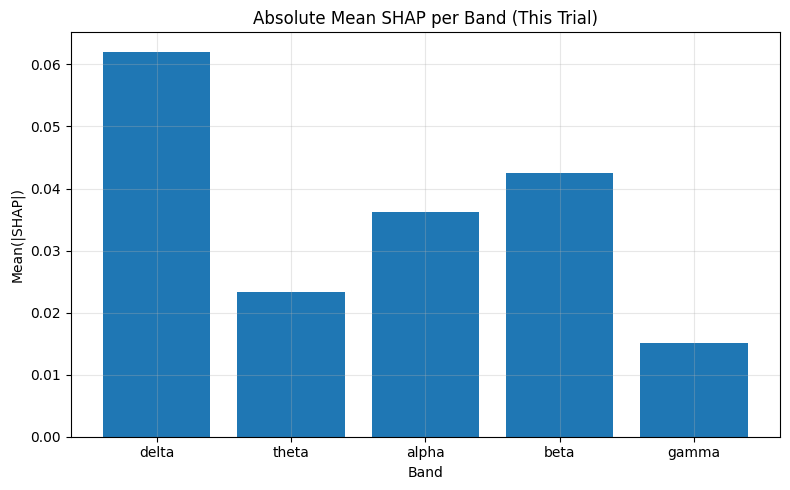

In [17]:
print("=" * 80)
print("[STEP 10] COMPUTING SHAP (MEAN ABS SHAP PER BAND FOR THIS TRIAL)")
print("=" * 80)

band_names = ["delta", "theta", "alpha", "beta", "gamma"]  # feature names

# Background (small subset of segments)
bg_n = min(50, X_seg_scaled.shape[0])      # background samples
exp_n = min(200, X_seg_scaled.shape[0])    # explain samples

bg_idx = np.random.choice(X_seg_scaled.shape[0], size=bg_n, replace=False)   # background idx
exp_idx = np.random.choice(X_seg_scaled.shape[0], size=exp_n, replace=False) # explain idx

X_bg = X_seg_scaled[bg_idx].astype(np.float32)   # background
X_exp = X_seg_scaled[exp_idx].astype(np.float32) # explained

print("Background samples:", X_bg.shape)
print("Explained samples :", X_exp.shape)

# ✅ GradientExplainer for TF/Keras
explainer = shap.GradientExplainer(model, X_bg)   # build explainer
shap_vals = explainer.shap_values(X_exp)          # compute SHAP

# shap may come as list for single output models
if isinstance(shap_vals, list):
    shap_vals = shap_vals[0]

print("Raw shap_vals shape:", np.array(shap_vals).shape)

# ✅ Fix shape: (N,5,1) -> (N,5)
shap_vals = np.squeeze(shap_vals)  # remove last dim if exists

print("Squeezed shap_vals shape:", shap_vals.shape)

# ✅ Mean absolute shap per feature (5,)
mean_abs_shap = np.mean(np.abs(shap_vals), axis=0).astype(float)  # (5,)
mean_abs_shap = mean_abs_shap.reshape(-1)  # ensure 1D

print("mean_abs_shap shape:", mean_abs_shap.shape)
print("mean_abs_shap:", mean_abs_shap)

# Build DataFrame
shap_band_df = pd.DataFrame({
    "Band": band_names,
    "MeanAbsSHAP": mean_abs_shap
})

print("\n✅ SHAP summary (mean abs) for this trial:")
print(shap_band_df)

# Plot
plt.figure(figsize=(8, 5))
plt.bar(band_names, mean_abs_shap)
plt.xlabel("Band")
plt.ylabel("Mean(|SHAP|)")
plt.title("Absolute Mean SHAP per Band (This Trial)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Save CSV
#out_csv = "shap_mean_abs_per_band_this_trial.csv"
#shap_band_df.to_csv(out_csv, index=False)
#print(f"✅ Saved: {out_csv}")


CELL 12 — Channel × Band gradient saliency table (avg across segments)

In [20]:
print("=" * 80)
print("[STEP 11] CHANNEL × BAND GRADIENT SALIENCY TABLE")
print("=" * 80)

# Electrode names (must match channel order)
electrode_names = [
    'Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2',
    'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz',
    'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2',
    'CPz', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'AF8', 'AF4', 'F2', 'F9', 'AFF1h', 'FFC1h', 'FFC5h', 'FTT7h',
    'FCC3h', 'CCP1h', 'CCP5h', 'TPP7h', 'P9', 'PPO9h', 'PO9', 'O9', 'OI1h', 'PPO1h', 'CPP3h', 'CPP4h', 'PPO2h', 'OI2h',
    'O10', 'PO10', 'PPO10h', 'P10', 'TPP8h', 'CCP6h', 'CCP2h', 'FCC4h', 'FTT8h', 'FFC6h', 'FFC2h', 'AFF2h', 'F10',
    'AFp1', 'AFF5h', 'FFT9h', 'FFT7h', 'FFC3h', 'FCC1h', 'FCC5h', 'FTT9h', 'TTP7h', 'CCP3h', 'CPP1h', 'CPP5h', 'TPP9h',
    'POO9h', 'PPO5h', 'POO1', 'POO2', 'PPO6h', 'POO10h', 'TPP10h', 'CPP6h', 'CPP2h', 'CCP4h', 'TTP8h', 'FTT10h',
    'FCC6h', 'FCC2h', 'FFC4h', 'FFT8h', 'FFT10h', 'AFF6h', 'AFp2'
]

# ---------------------------
# Sanity checks
# ---------------------------
C = int(X_clean.shape[0])  # number of channels
print(f"[STEP 11] Channels in X_clean: {C}")
print(f"[STEP 11] Segments in X_test_segments: {X_test_segments.shape[0]}")

if len(electrode_names) != C:
    print(f"⚠️ Electrode list length = {len(electrode_names)} but data has {C} channels.")
    if len(electrode_names) > C:
        electrode_names = electrode_names[:C]
        print(f"✅ Trimmed electrode list to {C}.")
    else:
        electrode_names = [f"EEG{i+1}" for i in range(C)]
        print(f"✅ Using auto-generated names EEG1..EEG{C}.")

# Band names (must match your BANDS dict order)
band_names = ["delta", "theta", "alpha", "beta", "gamma"]

# ---------------------------
# Build scaler constants for TF
# ---------------------------
sc_mean = tf.constant(scaler.mean_.astype(np.float32), dtype=tf.float32)    # (5,)
sc_scale = tf.constant(scaler.scale_.astype(np.float32), dtype=tf.float32) # (5,)

@tf.function
def wrapper_forward(x_ch_band):
    """
    x_ch_band: (B, C, 5) per-channel band logpowers
    - mean across channels -> (B,5)
    - apply scaler -> (B,5)
    - feed model -> (B,)
    """
    x_mean = tf.reduce_mean(x_ch_band, axis=1)                 # (B,5)
    x_scaled = (x_mean - sc_mean) / (sc_scale + 1e-12)         # (B,5)
    y = model(x_scaled, training=False)                        # (B,1)
    return y[:, 0]                                             # (B,)

def channel_band_logpowers(seg_2d, fs):
    """
    Compute per-channel log bandpower features for ONE segment.
    Input:
      seg_2d: (C, T) float32
    Output:
      feats_ch: (C,5) float32 [delta, theta, alpha, beta, gamma]
    """
    # ✅ MNE filter requires float64
    seg_64 = seg_2d.astype(np.float64, copy=False)

    feats_ch = np.zeros((seg_64.shape[0], 5), dtype=np.float32)

    # Ensure stable band order
    bands_list = list(BANDS.items())  # [(name,(l,h)), ...]

    for j, (band, (l, h)) in enumerate(bands_list):
        band_sig = mne.filter.filter_data(
            seg_64,
            sfreq=float(fs),
            l_freq=float(l),
            h_freq=float(h),
            verbose=False
        )
        power_ch = np.mean(band_sig ** 2, axis=1)                         # (C,)
        feats_ch[:, j] = np.log(power_ch + 1e-12).astype(np.float32)      # (C,)

    return feats_ch

# ---------------------------
# Compute gradients per segment
# ---------------------------
print("[STEP 11] Computing gradients for each segment...")

all_grads = []  # will store (C,5) per segment

for i in tqdm(range(X_test_segments.shape[0]), desc="Grad saliency (segments)"):
    # (C,5) per-channel band logpower matrix
    Xcb = channel_band_logpowers(X_test_segments[i], fs)

    # add batch dim -> (1,C,5)
    Xcb_b = Xcb[np.newaxis, ...].astype(np.float32, copy=False)

    # to tensor
    x_tensor = tf.convert_to_tensor(Xcb_b, dtype=tf.float32)

    # gradients
    with tf.GradientTape() as tape:
        tape.watch(x_tensor)
        y = wrapper_forward(x_tensor)      # (1,)
    grads = tape.gradient(y, x_tensor)     # (1,C,5)

    # absolute gradients -> (C,5)
    grads_abs = tf.abs(grads)[0].numpy().astype(np.float32)
    all_grads.append(grads_abs)

all_grads = np.array(all_grads, dtype=np.float32)  # (n_seg, C, 5)
print("✅ all_grads shape:", all_grads.shape)

# Average across segments -> (C,5)
mean_saliency = np.mean(all_grads, axis=0).astype(np.float32)
print("✅ mean_saliency shape:", mean_saliency.shape)

# Build table DataFrame
saliency_df = pd.DataFrame(mean_saliency, index=electrode_names, columns=band_names)
saliency_df.index.name = "Electrode"

print("✅ Saliency table created:", saliency_df.shape)
print(saliency_df.head())

# Save CSV
out_csv = "gradient_saliency_channel_x_band_this_trial.csv"
saliency_df.to_csv(out_csv)
print(f"✅ Saved: {out_csv}")


[STEP 11] CHANNEL × BAND GRADIENT SALIENCY TABLE
[STEP 11] Channels in X_clean: 127
[STEP 11] Segments in X_test_segments: 75
[STEP 11] Computing gradients for each segment...


Grad saliency (segments):   0%|          | 0/75 [00:00<?, ?it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_22816\317019226.py:73: RuntimeWarning: filter_length (3301) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  band_sig = mne.filter.filter_data(
Grad saliency (segments):   1%|▏         | 1/75 [00:00<00:39,  1.86it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_22816\317019226.py:73: RuntimeWarning: filter_length (3301) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  band_sig = mne.filter.filter_data(
Grad saliency (segments):   3%|▎         | 2/75 [00:00<00:26,  2.76it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_22816\317019226.py:73: RuntimeWarning: filter_length (3301) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  band_sig = mne.filter.filter_data(
Grad saliency (segments):   4%|▍         | 3/75 [00:01<00:22,  3.2

✅ all_grads shape: (75, 127, 5)
✅ mean_saliency shape: (127, 5)
✅ Saliency table created: (127, 5)
              delta     theta    alpha      beta     gamma
Electrode                                                 
Fp1        0.000484  0.000857  0.00115  0.001444  0.003671
Fz         0.000484  0.000857  0.00115  0.001444  0.003671
F3         0.000484  0.000857  0.00115  0.001444  0.003671
F7         0.000484  0.000857  0.00115  0.001444  0.003671
FT9        0.000484  0.000857  0.00115  0.001444  0.003671
✅ Saved: gradient_saliency_channel_x_band_this_trial.csv


[STEP 12] TOPOGRAPHY PLOTS (ONE PER BAND)
✅ Montage matched channels: 125 / 127
Bands to plot: ['delta', 'theta', 'alpha', 'beta', 'gamma']
--------------------------------------------------------------------------------
[STEP 12] Plotting topomap for band: delta


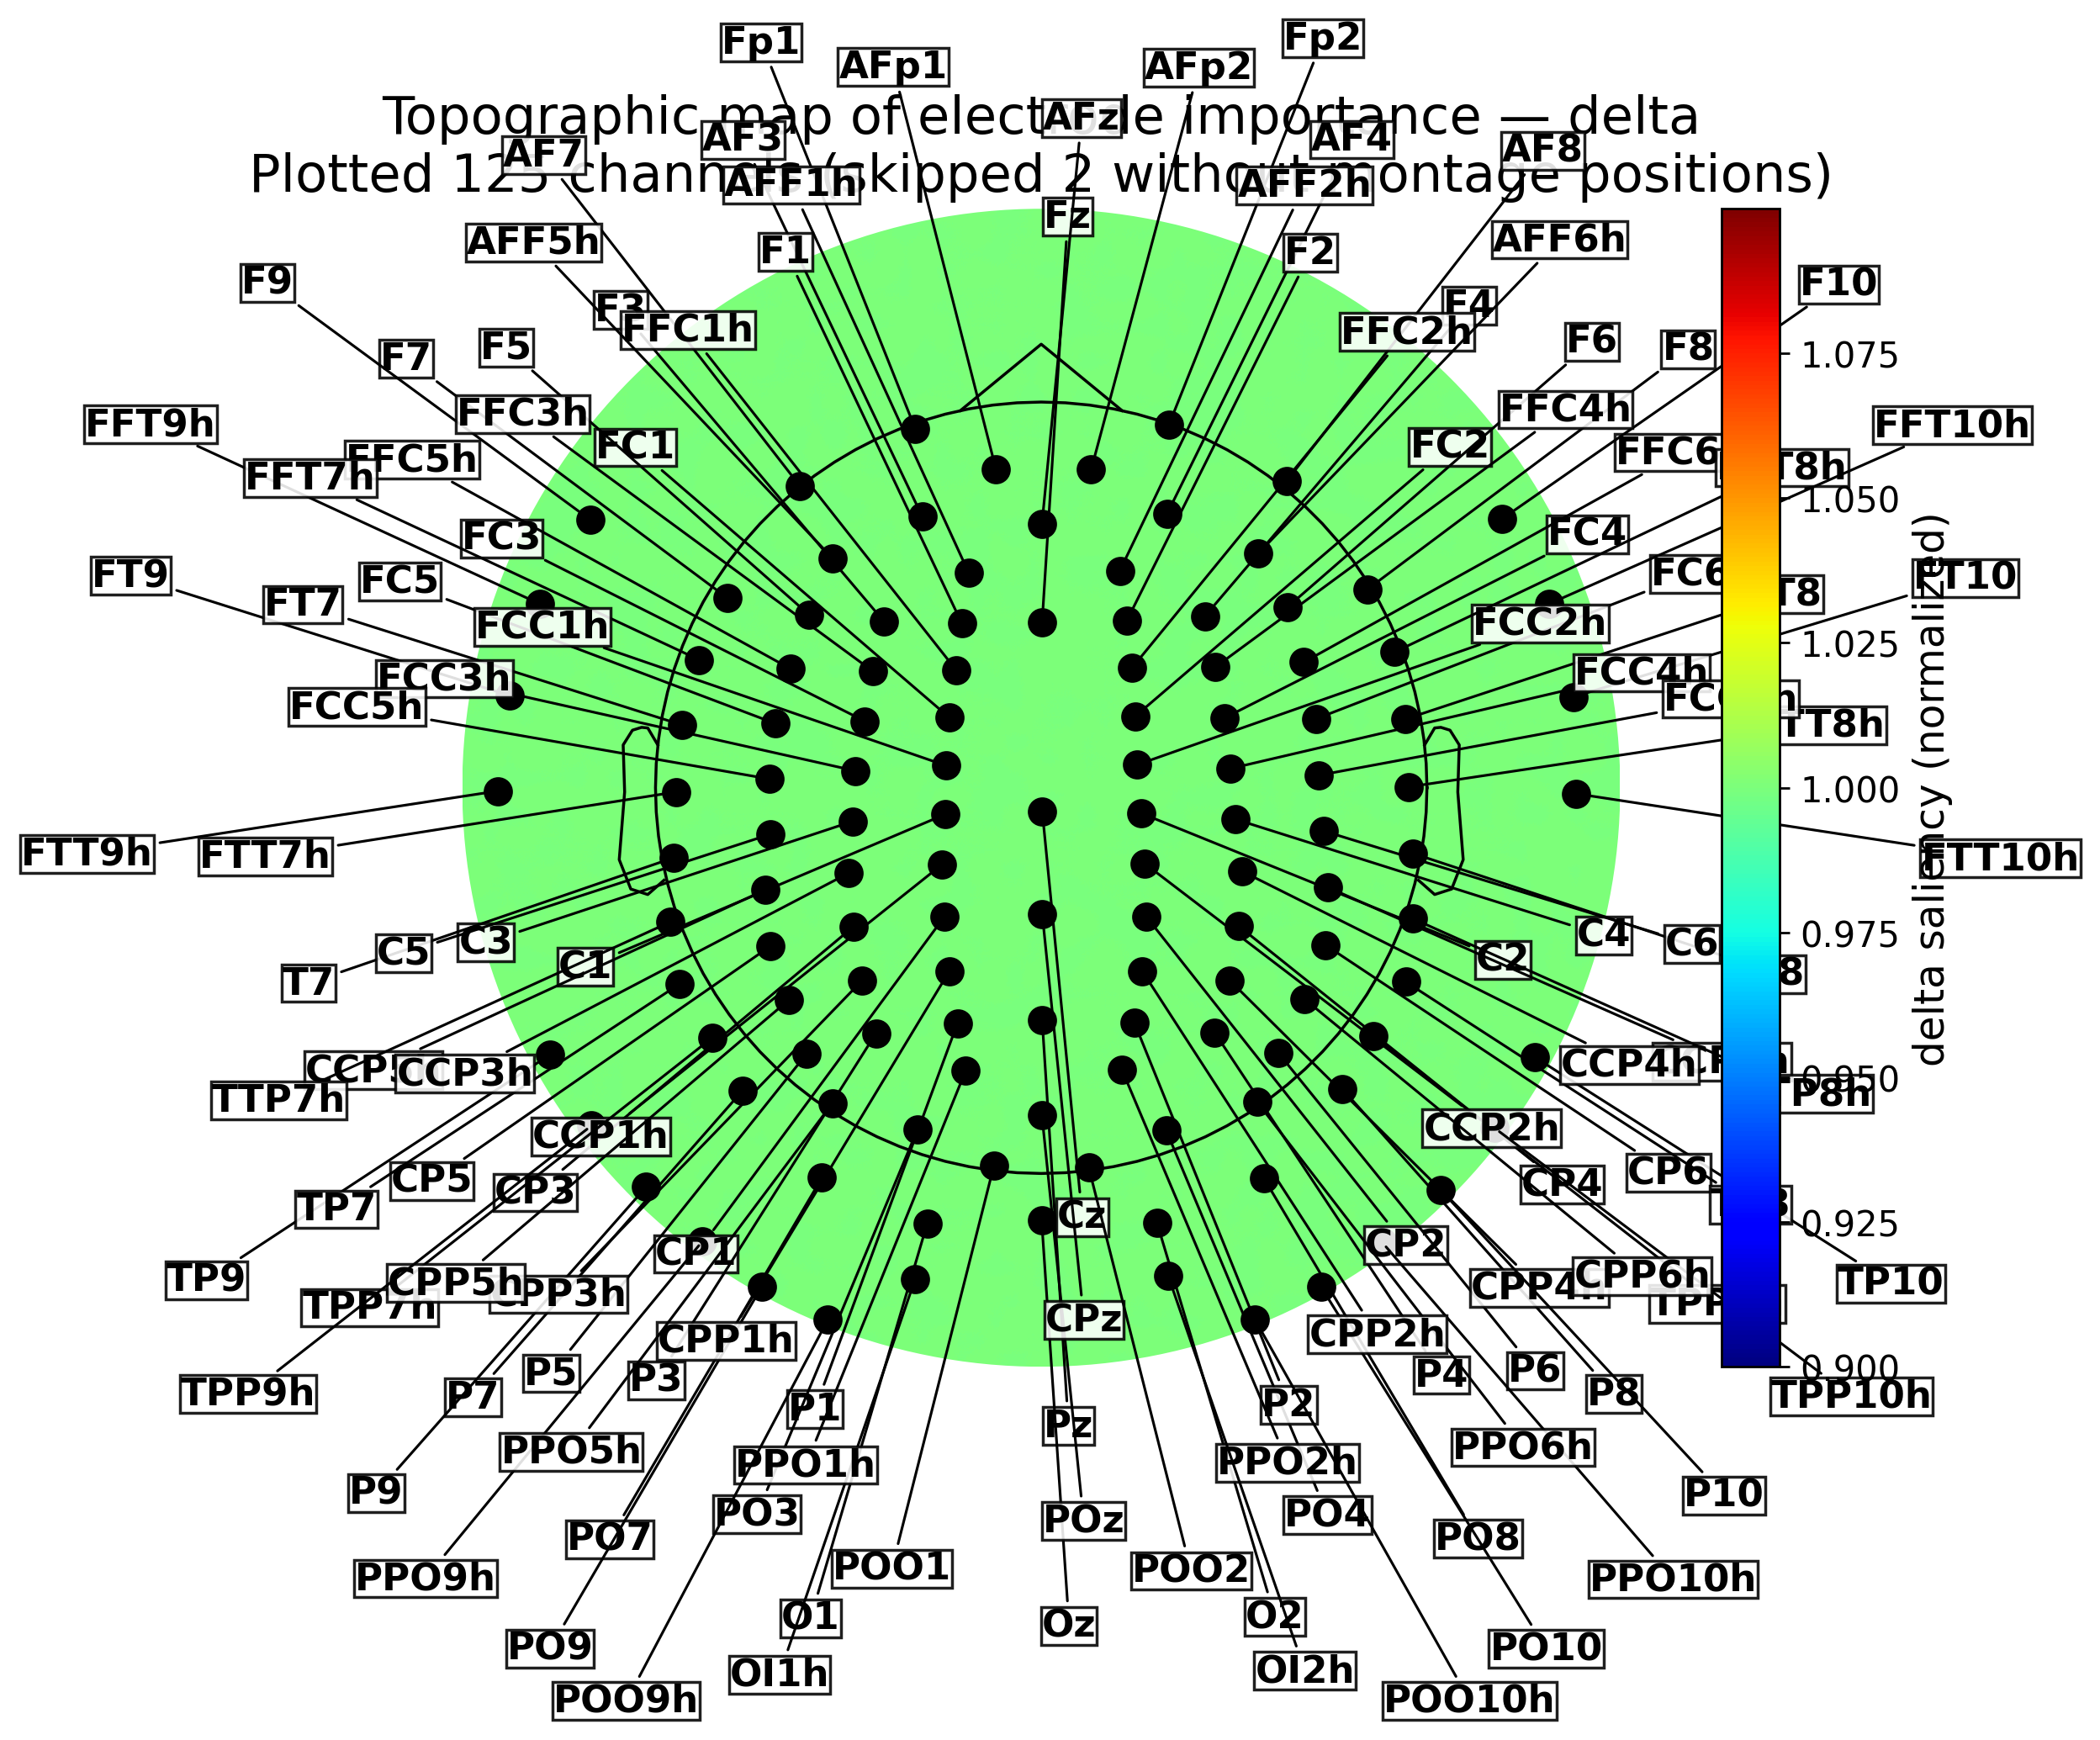

--------------------------------------------------------------------------------
[STEP 12] Plotting topomap for band: theta


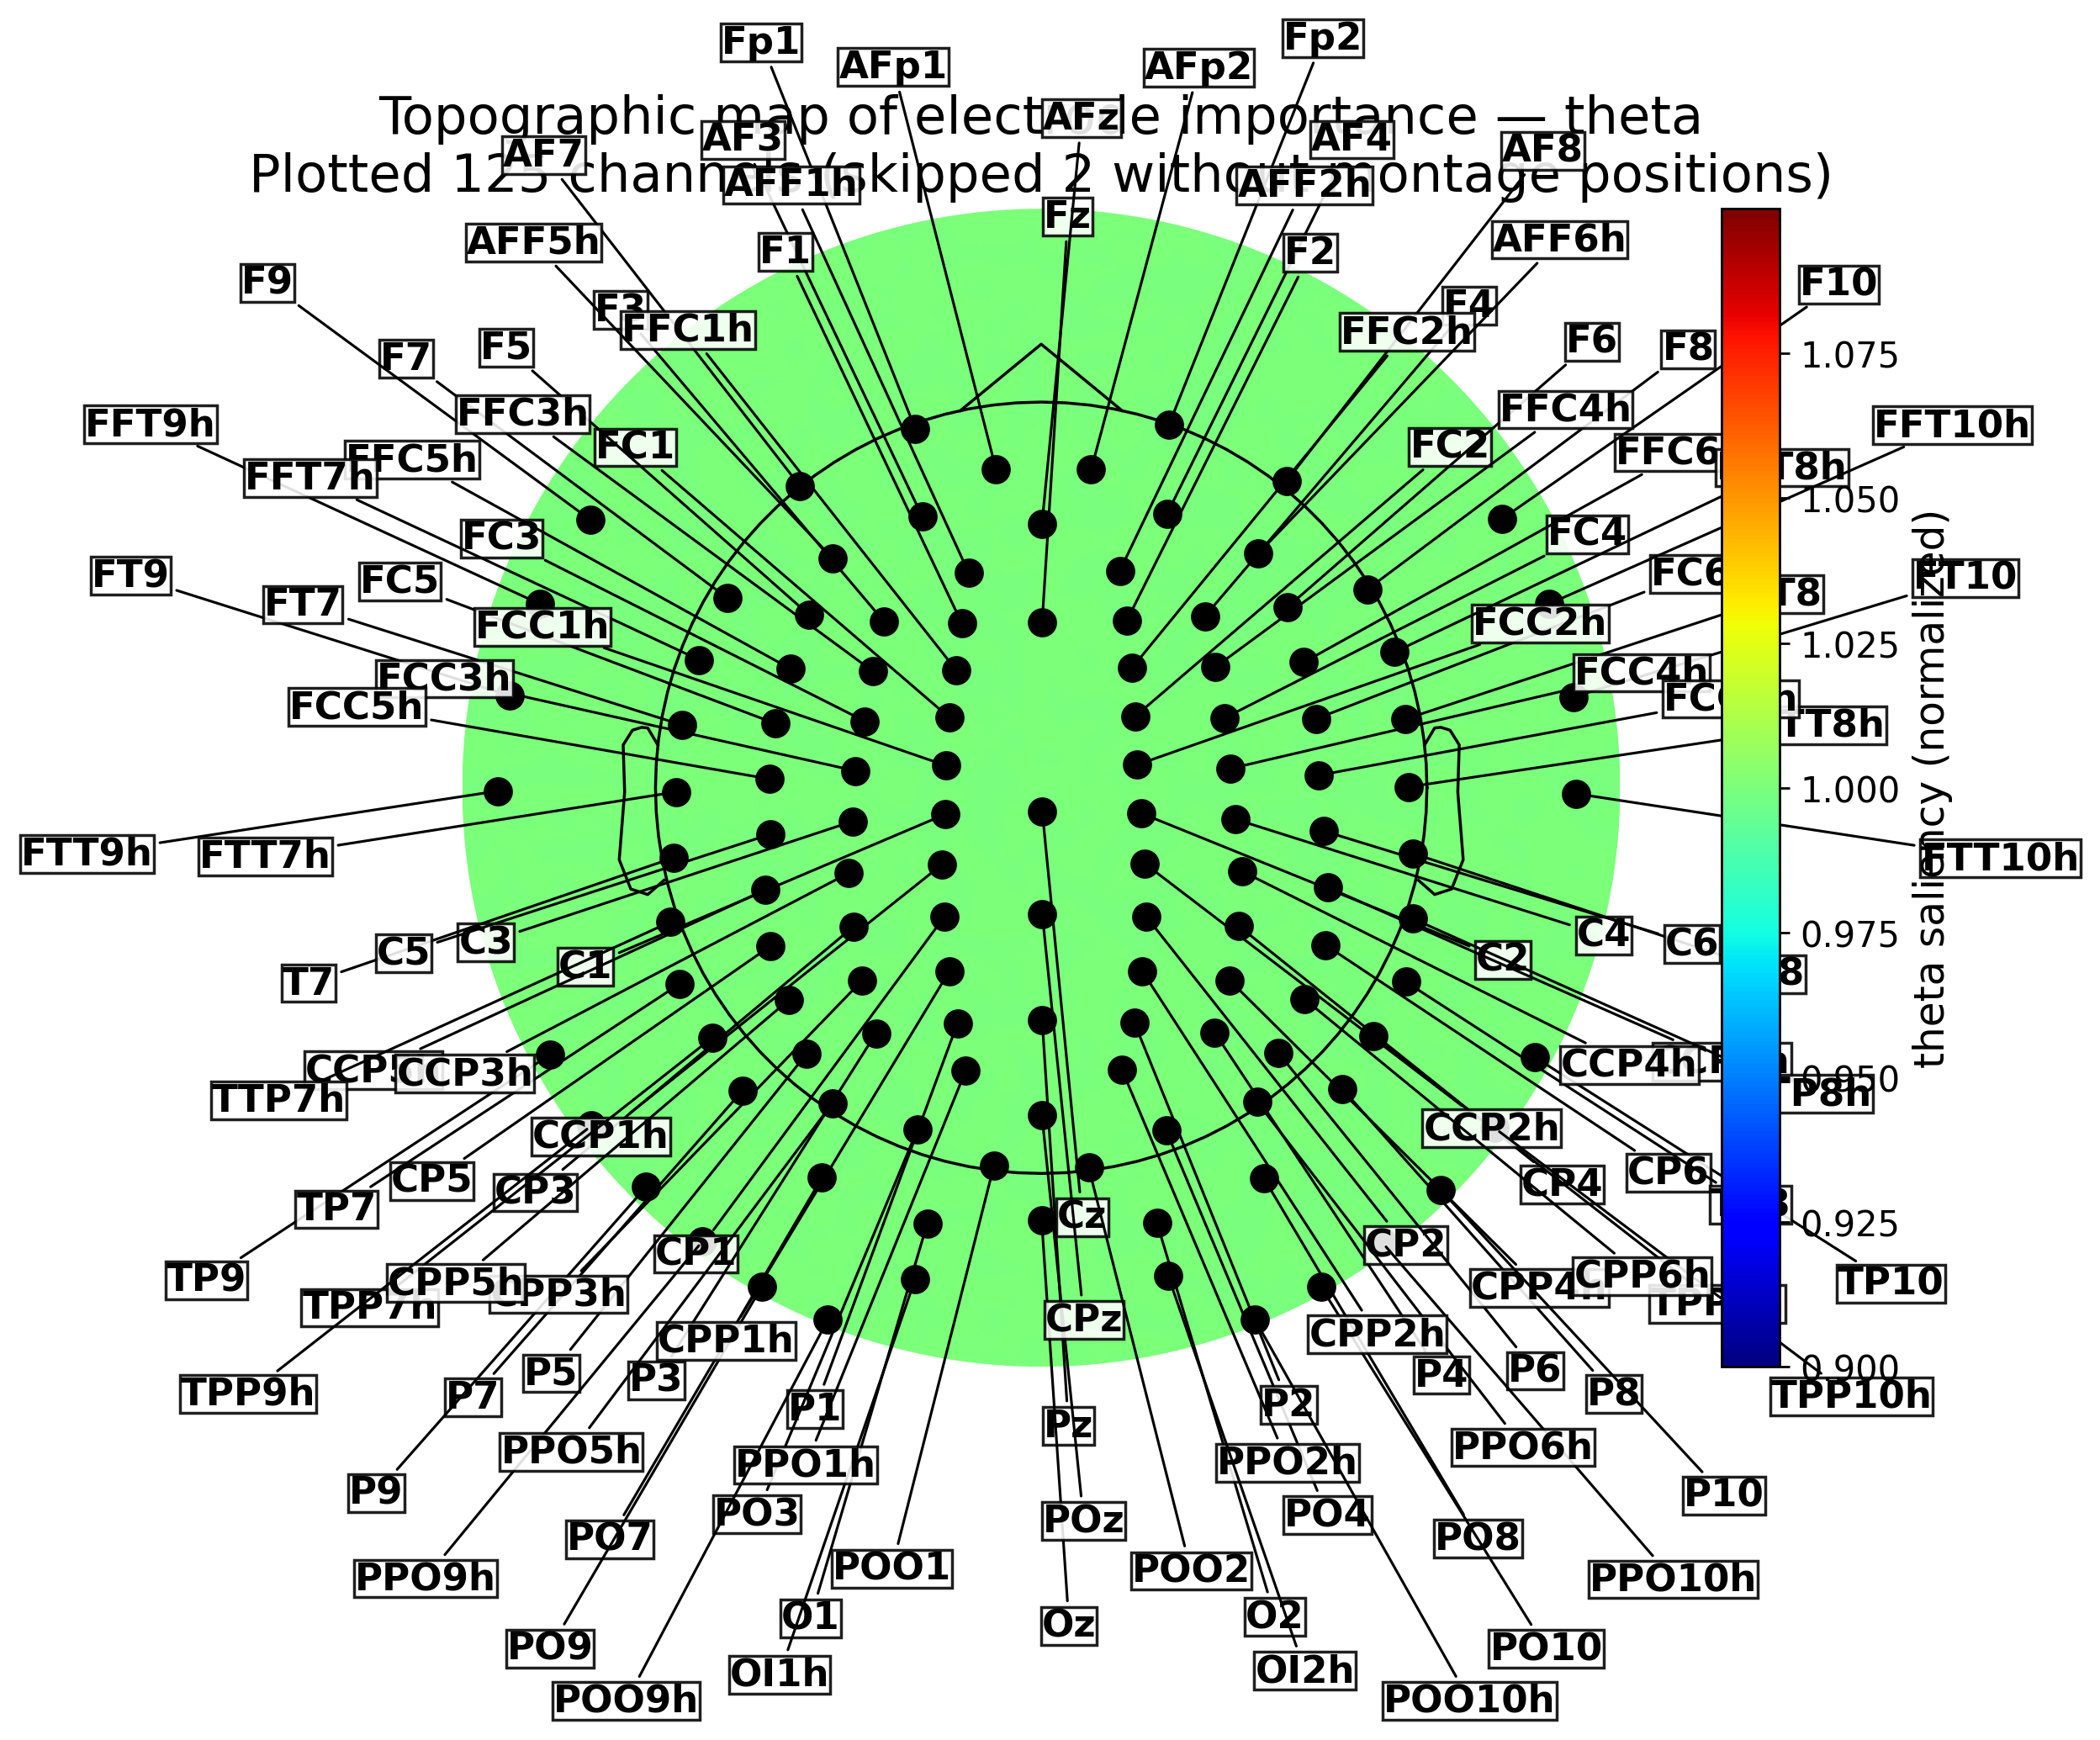

--------------------------------------------------------------------------------
[STEP 12] Plotting topomap for band: alpha


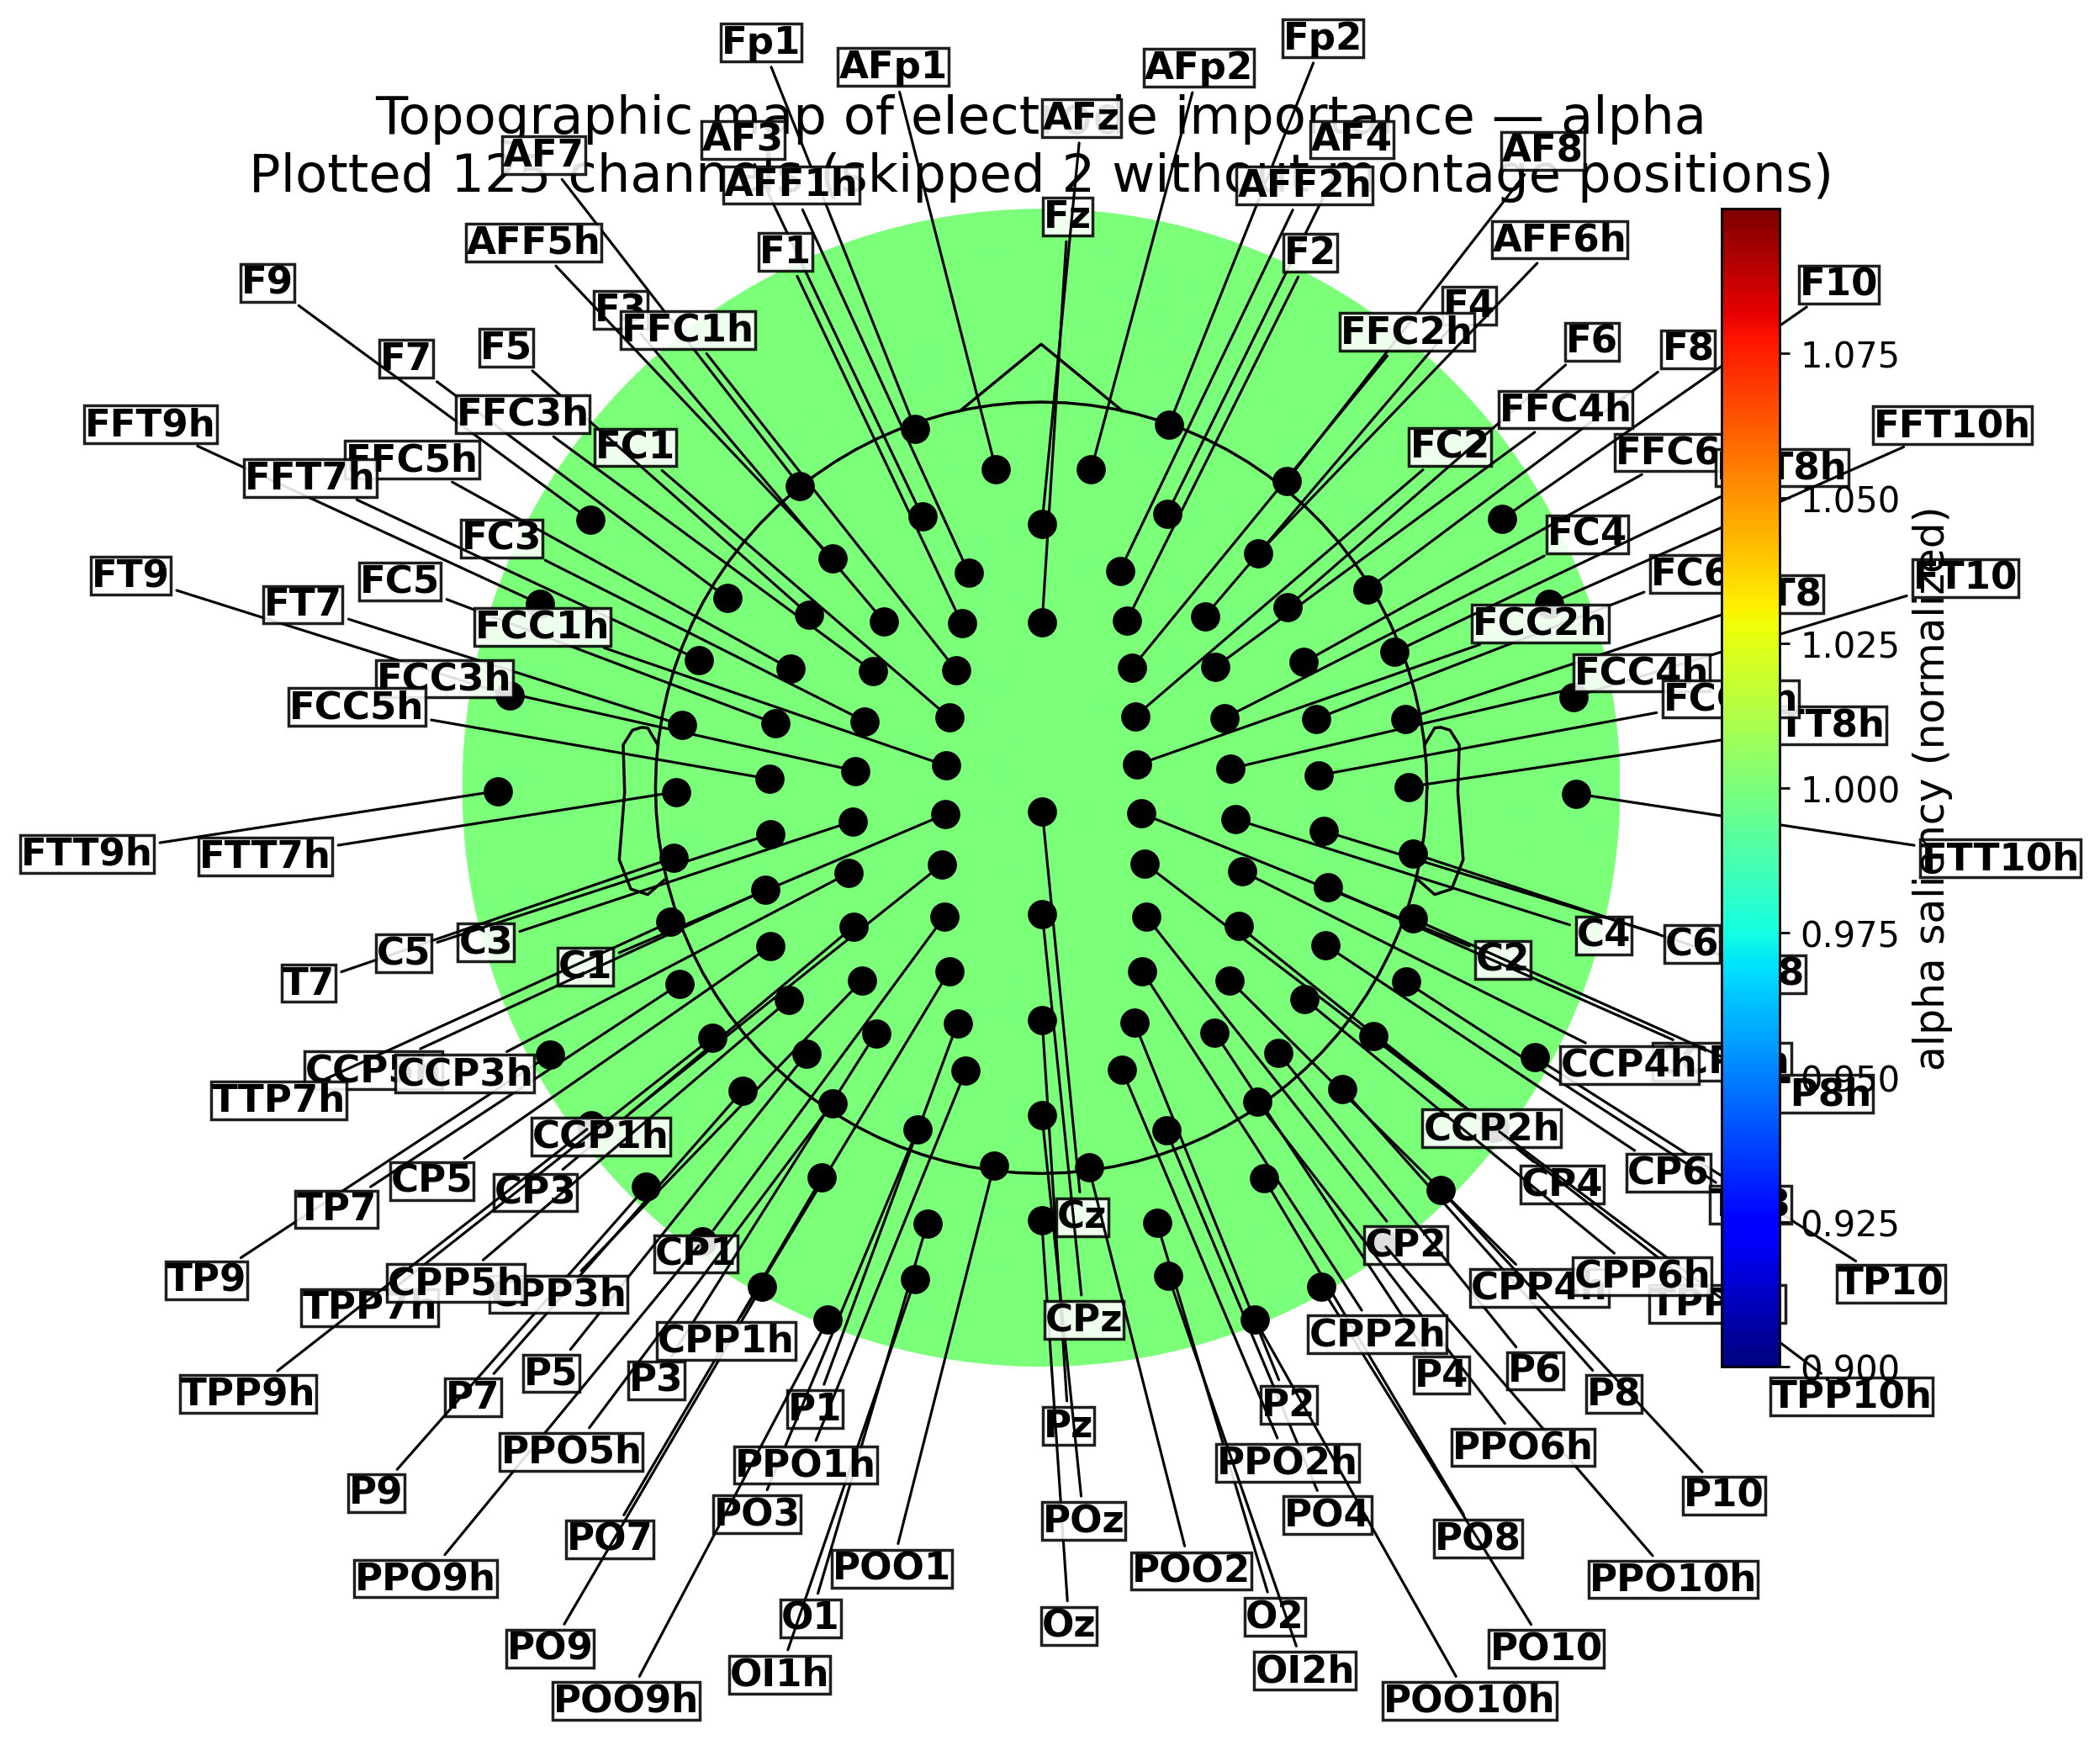

--------------------------------------------------------------------------------
[STEP 12] Plotting topomap for band: beta


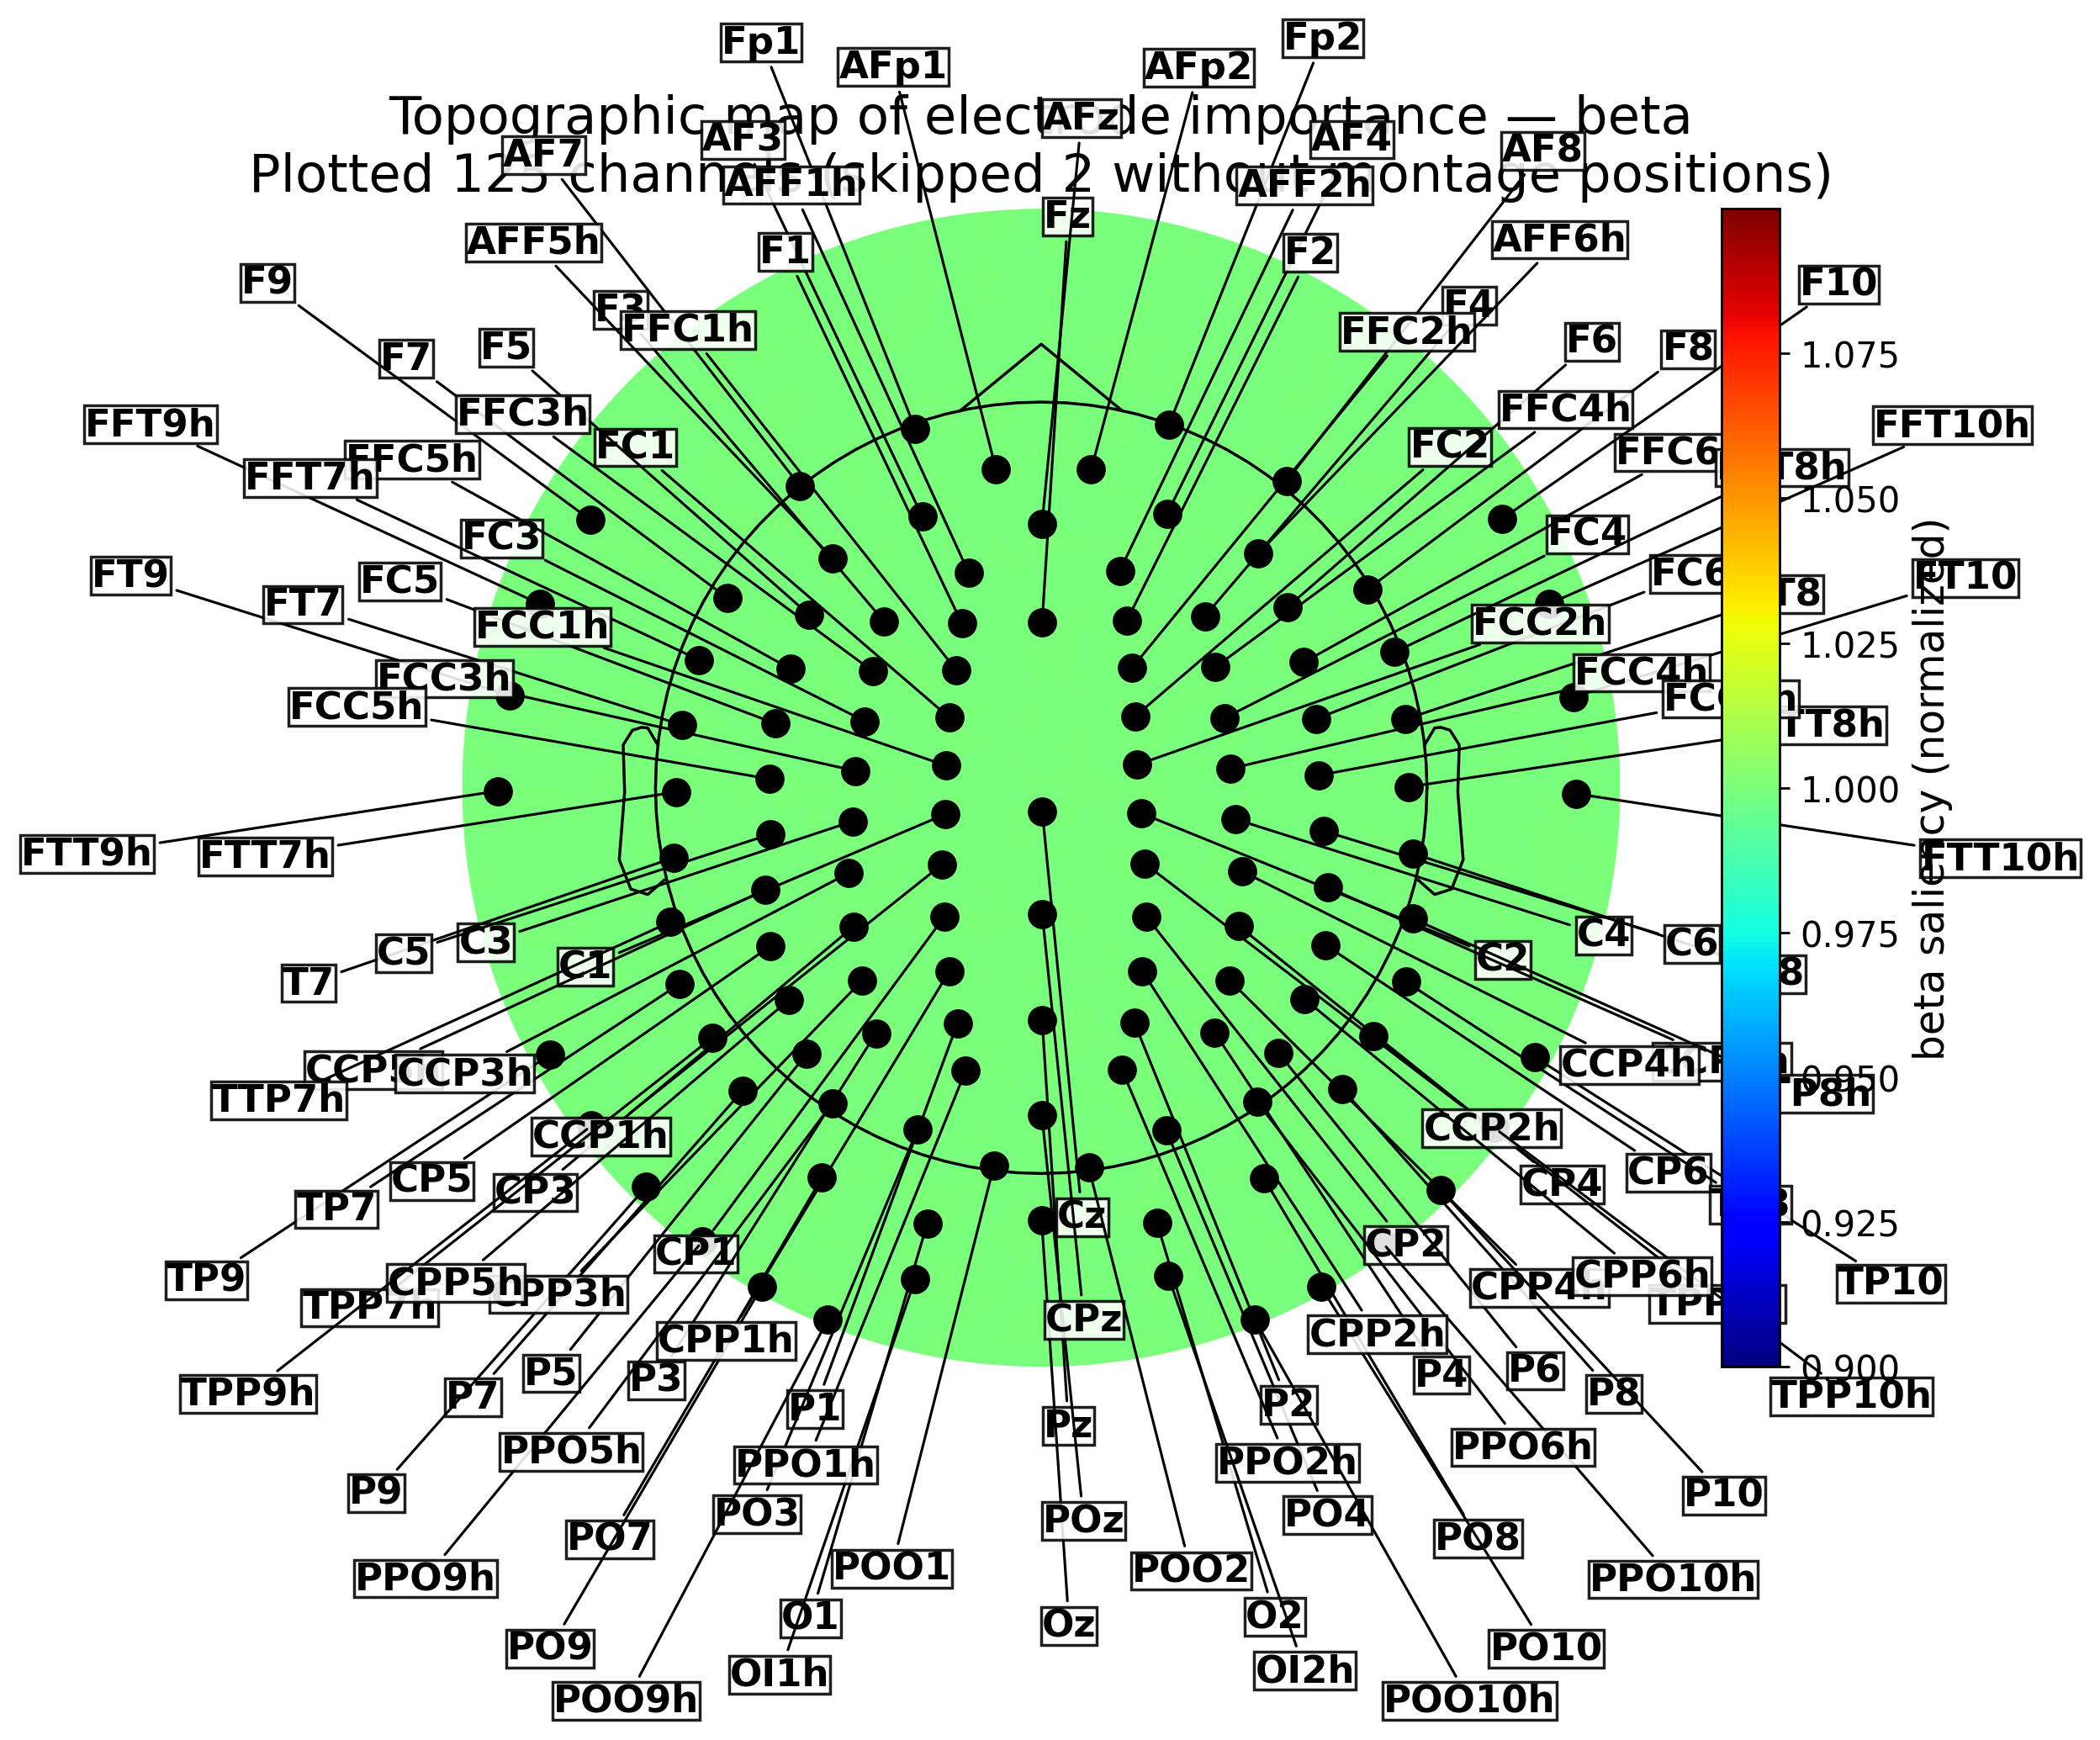

--------------------------------------------------------------------------------
[STEP 12] Plotting topomap for band: gamma


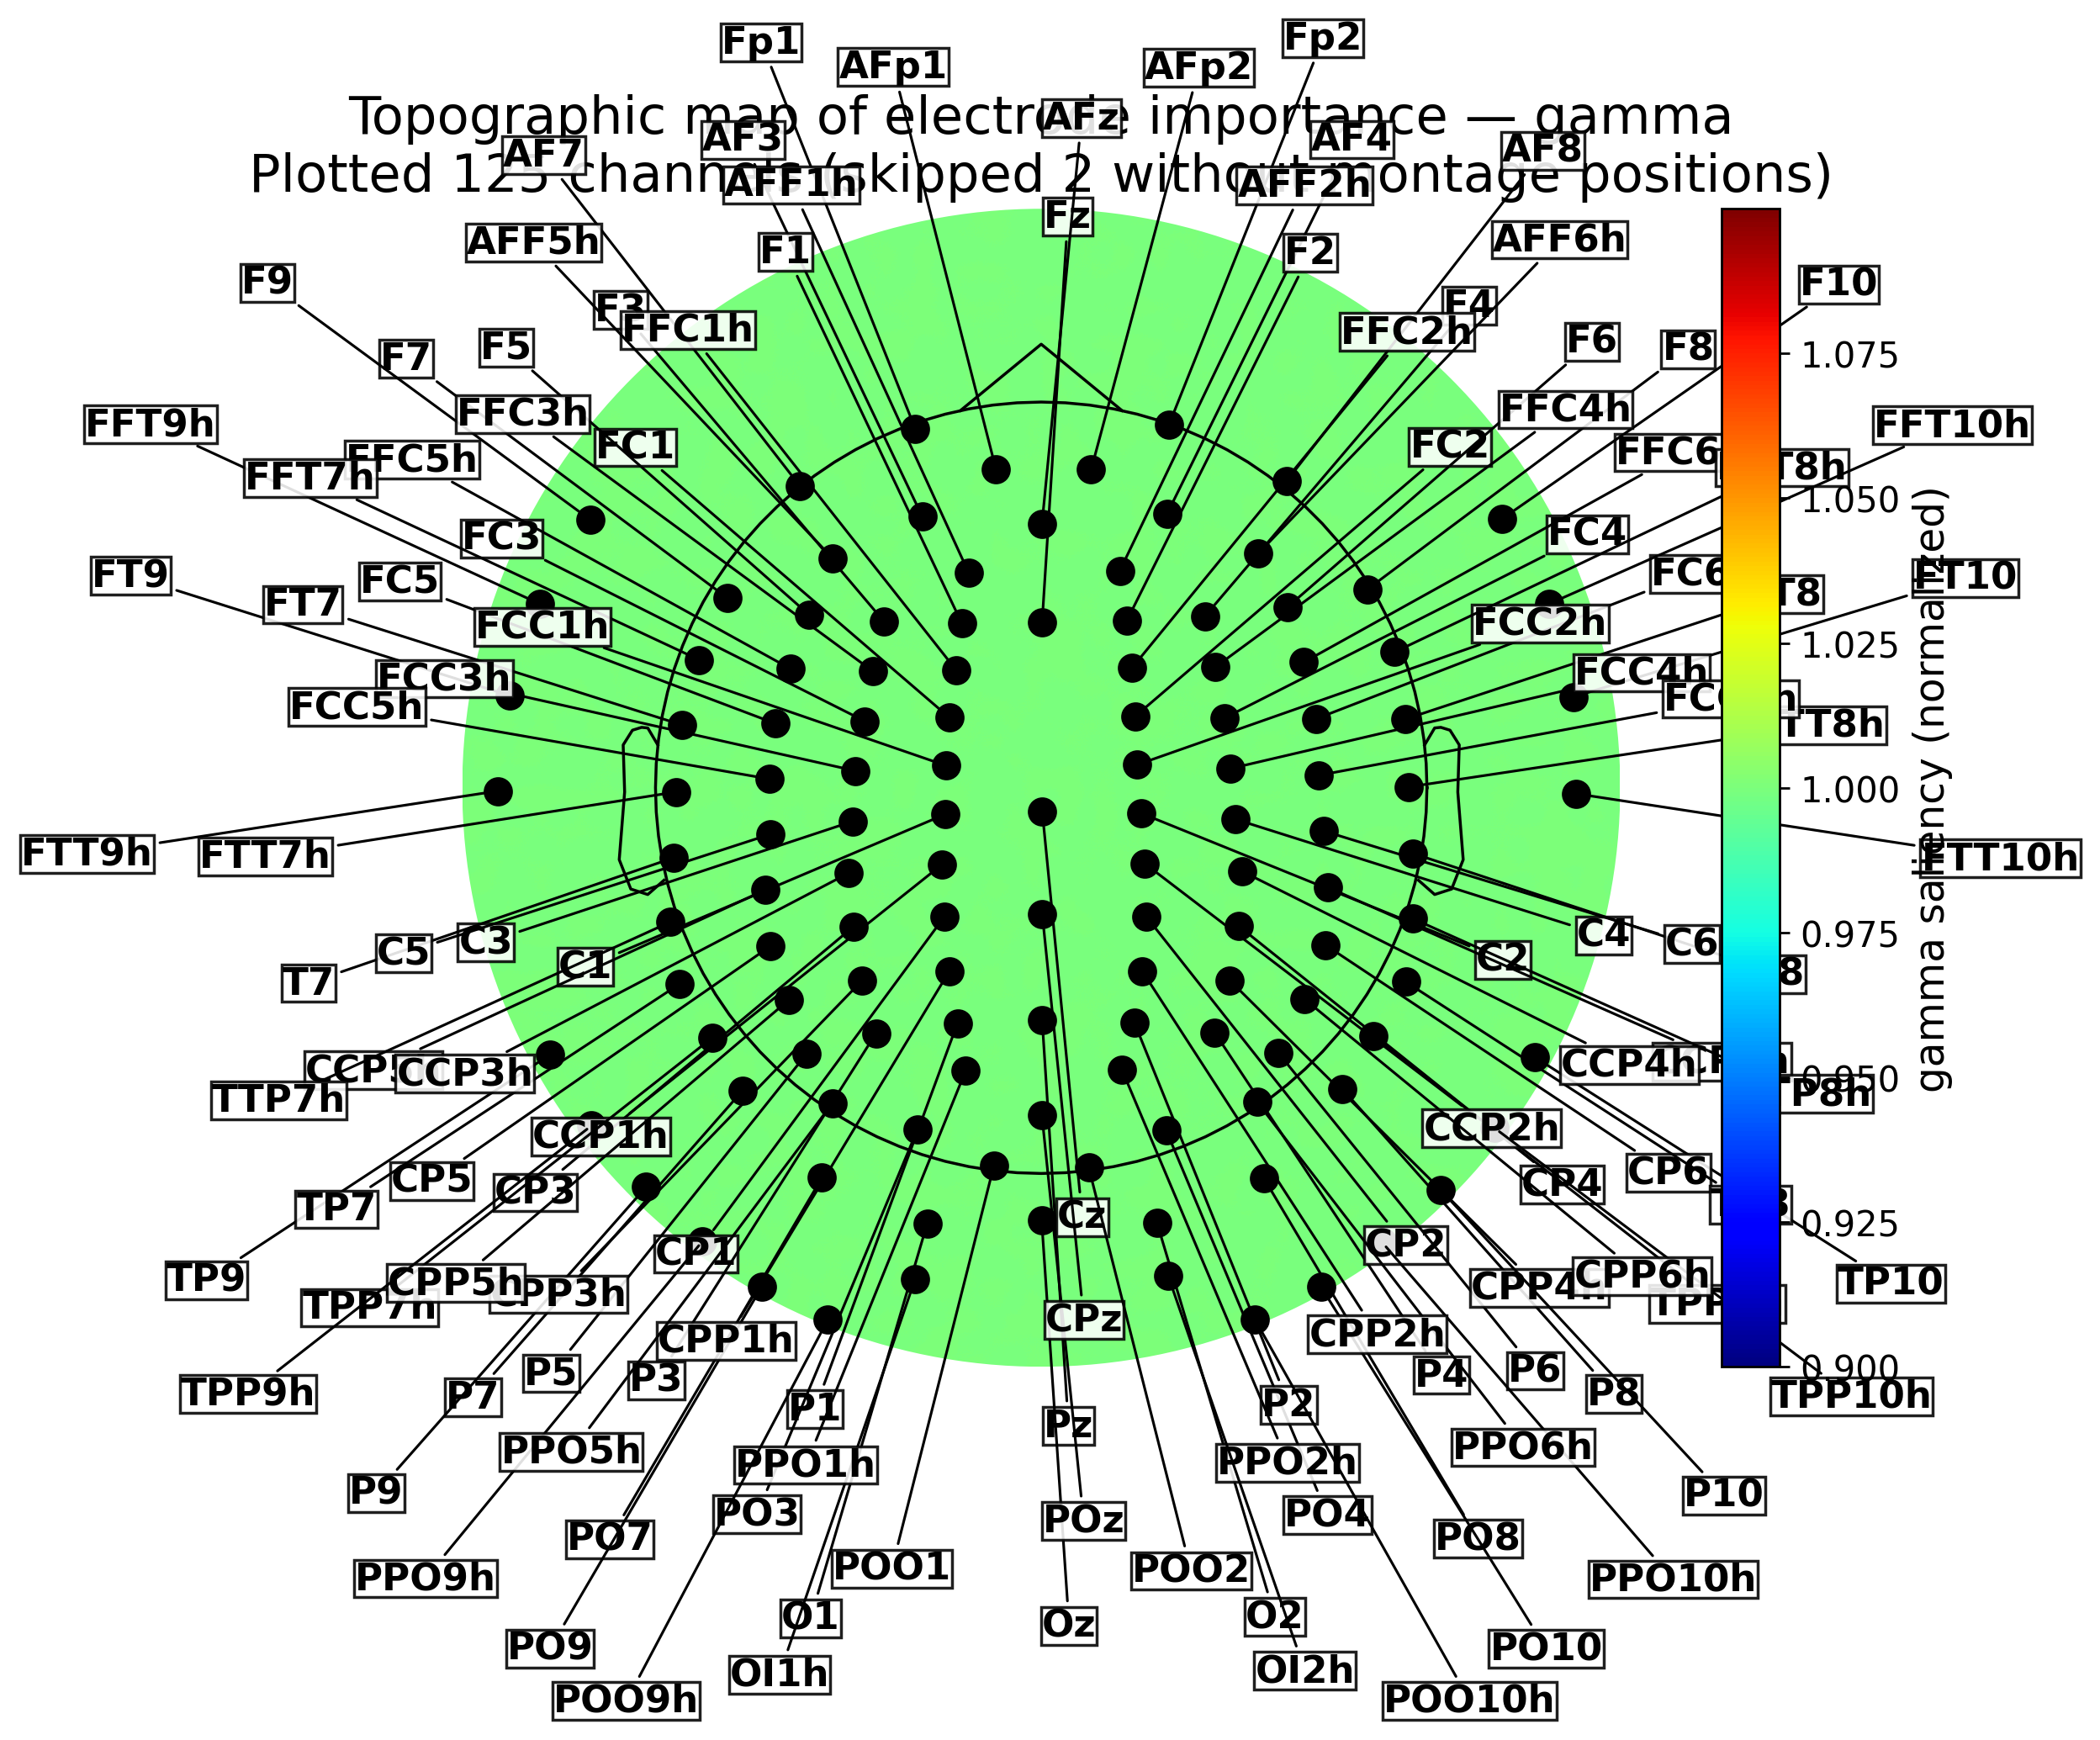

✅ All band-wise topomaps plotted.


In [22]:
print("=" * 80)
print("[STEP 12] TOPOGRAPHY PLOTS (ONE PER BAND)")
print("=" * 80)

# ---------------------------
# Helper: montage name mapping (AFF1h -> AFF1)
# ---------------------------
def montage_lookup_name(name: str) -> str:
    n = name.strip()
    if n.endswith("h") and len(n) > 1:
        return n[:-1]
    return n

# ---------------------------
# Common electrode list from saliency_df
# ---------------------------
ch_names_orig = saliency_df.index.astype(str).tolist()  # channel names
ch_names_lookup = [montage_lookup_name(n) for n in ch_names_orig]  # lookup names

# Use standard_1005 montage
base_montage = mne.channels.make_standard_montage("standard_1005")
base_pos = base_montage.get_positions()["ch_pos"]

# Create custom positions (same for all bands)
ch_pos_custom = {}
keep_idx = []
for i, (orig, look) in enumerate(zip(ch_names_orig, ch_names_lookup)):
    if look in base_pos:
        ch_pos_custom[orig] = base_pos[look]
        keep_idx.append(i)

if len(keep_idx) == 0:
    raise RuntimeError("❌ No channels matched montage. Try another montage or custom positions.")

# Keep only matched channels (fixed set across all band plots)
ch_names = [ch_names_orig[i] for i in keep_idx]

# Create info and apply montage (fixed)
info = mne.create_info(ch_names=ch_names, sfreq=fs, ch_types="eeg")
custom_montage = mne.channels.make_dig_montage(ch_pos=ch_pos_custom, coord_frame="head")
info.set_montage(custom_montage, on_missing="ignore")

# Precompute 2D coords once (fixed)
coords2d = mne.channels.layout._find_topomap_coords(info, picks=np.arange(len(ch_names)))

print(f"✅ Montage matched channels: {len(ch_names)} / {len(ch_names_orig)}")
print("Bands to plot:", list(saliency_df.columns))

# ---------------------------
# Plot settings
# ---------------------------
dot_size = 18
font_size = 13
arrow_lw = 0.9

# ---------------------------
# Loop through each band and plot separately
# ---------------------------
for band in saliency_df.columns:
    print("-" * 80)
    print(f"[STEP 12] Plotting topomap for band: {band}")

    # Extract band values for matched channels
    values_orig = saliency_df[band].to_numpy(dtype=float)  # (C,)
    values = values_orig[keep_idx]  # matched channels only

    # Normalize to [0, 1] for visualization
    values = values / (np.max(values) + 1e-8)

    # Plot
    fig, ax = plt.subplots(figsize=(14, 9), dpi=250)

    vmin, vmax = float(values.min()), float(values.max())

    im, cn = mne.viz.plot_topomap(
        values,
        info,
        axes=ax,
        show=False,
        contours=6,
        sensors=False,
        outlines="head",
        vlim=(vmin, vmax),
        cmap="jet",
    )

    # Big dots + labels
    for (x, y), name in zip(coords2d, ch_names):
        ax.plot(x, y, "k.", markersize=dot_size, zorder=10)

        r = np.sqrt(x * x + y * y) + 1e-9
        ux, uy = x / r, y / r

        offset_out = 0.085
        offset_lift = 0.015
        x_text = x + ux * offset_out
        y_text = y + uy * offset_out + (offset_lift if y >= 0 else -offset_lift)

        ax.annotate(
            name,
            xy=(x, y),
            xytext=(x_text, y_text),
            textcoords="data",
            fontsize=font_size,
            fontweight="bold",
            ha="left" if x_text >= x else "right",
            va="center",
            bbox=dict(facecolor="white", edgecolor="black", alpha=0.88, pad=0.25),
            arrowprops=dict(arrowstyle="-", color="black", lw=arrow_lw),
            zorder=11,
        )

    # Colorbar + title
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label(f"{band} saliency (normalized)", fontsize=14)
    cbar.ax.tick_params(labelsize=12)

    missing = len(ch_names_orig) - len(ch_names)
    ax.set_title(
        f"Topographic map of electrode importance — {band}\n"
        f"Plotted {len(ch_names)} channels (skipped {missing} without montage positions)",
        fontsize=18,
    )

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

print("✅ All band-wise topomaps plotted.")
